## A/B Testing

We have seen several examples of assessing whether a single sample looks like random draws from a specified chance model. In all of these cases there was just one random sample, and we were trying to decide how it had been generated. 

But often, data scientists have to *compare two random samples* with each other. In modern data analytics, deciding whether two numerical samples come from the same underlying distribution is called **A/B testing**. The name refers to the labels of the two samples, A and B. In this lab, we will use A/B testing for one particular example.

In [1]:
# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Respiratory Illness Data

We have [data](https://vincentarelbundock.github.io/Rdatasets/datasets.html) from a clinical trial of patients with respiratory illness, where 111 patients from two different clinics were randomized to receive either placebo or an active treatment. Patients were examined at baseline and at four visits during treatment. At each examination, respiratory status (categorized as 1 = good, 0 = poor) was determined. Below, we load the dataset and select only the last examination of each patient (visit = 4) to decide whether the treatment was effective or not.

In [2]:
respiratory = Table.read_table("respiratory.csv").where("visit", are.equal_to(4))
respiratory

Unnamed: 0,center,id,treat,sex,age,baseline,visit,outcome
4,1,1,P,M,46,0,4,0
8,1,2,P,M,28,0,4,0
12,1,3,A,M,23,1,4,1
16,1,4,P,M,44,1,4,0
20,1,5,P,F,13,1,4,1
24,1,6,A,M,34,0,4,0
28,1,7,P,M,43,0,4,1
32,1,8,A,M,28,0,4,0
36,1,9,A,M,31,1,4,1
40,1,10,P,M,37,1,4,0


### Was the Treatment Effective?

In the following, we will conduct an A/B testing to decide whether the treatment was effective or not. In fact, we want to answer this question that whether those who received active treatment are on average in better health status than the rest or not.

#### Treatment and Control Groups

**Question 1.** What are the treatment and control groups in our A/B testing process?

Treatment group: those who recived active medicine.

Control group: those who recived placebo.

#### Null and Alternative Hypotheses

**Question 2.** What are the null and alternative hypotheses in our A/B testing process?

Null hypothesis: both samples come from the same distribution. the treatment does not have any effect. if we observe something different it is only because of the chance. 

Alternative hypothesis: no. on average, patients who recived the active medicine have a better/higher health status. the treatment was effective.

#### Test Statistic

**Question 3.** Define a test statistic function for this A/B testing process. The function should take a table and the name of a column. The function should consider the values of that column as a label, divide the patients based on that label into the treatment and control groups, and then calculate the difference of average patient's health status of these two groups as the test statistic. Run this function on the current dataset to get the observed test statistic.

In [3]:
def compute_test_statistic(table, label):
    control = table.where(label, are.equal_to("P"))
    treatment = table.where(label, are.equal_to("A"))
    return np.average(treatment.column("outcome")) - np.average(control.column("outcome"))



observed_test_statistic = compute_test_statistic(respiratory, "treat")
observed_test_statistic

0.172514619883041

#### Simulation with Permutation Test

To see how the statistic should vary under the null hypothesis, we have to figure out how to simulate the statistic under that hypothesis. A clever method based on random permutations does just that. Tests based on random permutations of the data are called *permutation tests*. If there were no difference between the two distributions in the underlying population, then whether a patient has been in the treatment or control group should make no difference to her final health status. The idea, then, is to shuffle all the labels randomly among the patients. This is called random permutation.

**Question 4.** Conduct a simulation with permutation test. In fact, you should conduct an experiment 5000 times and store the resulting test statistic of each experiment inside the array `test_statistics`. In each experiment, you should randomly shuffle the treatment label of the patients and then calculate the test statistic on the dataset with the shuffled labels.

*Hint:* To randomly shuffle the labels, you can sample the table without replacement and then select the column `treat` of this sampled table. Then, you can add this column to the original table as `shuffled treat`.

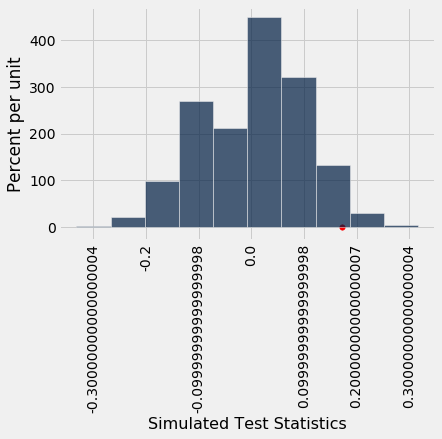

In [6]:
repetitions = 5000
test_statistics = make_array()

for i in np.arange(repetitions):
    random_labels = respiratory.sample(with_replacement=False).column("treat")
    new_table = respiratory.with_column("shuffled treat", random_labels)
    ts = compute_test_statistic(new_table, "shuffled treat")
    test_statistics = np.append(test_statistics, ts)



t = Table().with_column('Simulated Test Statistics', test_statistics)
t.hist()
plt.scatter(observed_test_statistic, 0, color='red', s=30)

#### P-Value

**Question 5.** Calculate the p-value to conclude the test. Can we reject the null hypothesis or we fail to do so? Was this treatment effective for curing respiratory illness?

In [7]:
p_value = np.count_nonzero(test_statistics >= observed_test_statistic) / len(test_statistics)
p_value

0.0542

Since the p-value is greater than 0.05 \[less than 0.05 / grater or equal than 0.05\], we cannot \[can / cannot\] reject the null hypothesis. Thus, the treatment was ineffective \[effective / ineffective\].